In [627]:
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import json

import re

import pickle

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

import nltk
from nltk.corpus import stopwords

from pymystem3 import Mystem

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [628]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/artemiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/artemiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [629]:
DATASET_PATH = './data/data.json'

In [630]:
with open(DATASET_PATH, 'r') as file:
    data = json.load(file)

max_length = max([len(data[elem]) for elem in data])

for elem in data:
    while len(data[elem]) < max_length:
        data[elem].append('')
        
max_length

1500

In [631]:
data = json.dumps(data)

In [632]:
df = pd.read_json(data)

df

/var/folders/m1/7thbrsg96m1_wm0p48jm8d7c0000gn/T/ipykernel_17780/792015447.py:1: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(data)


,АВТО БАТЯ,АЭРОФЛОТ,Телеграмма РЖД
0,Зачем переплачивать за доставку\n\n[АВТО БАТЯ]...,,
1,«Сравни.ру» огласил победителя ежегодной преми...,,
2,В Нигерии толпа собралась посмотреть на горящу...,,
3,"**Фургон задавил челябинку, которая отвлеклась...",,
4,[МФЦ](https://t.me/+wk0wdjBDPJJmMWMy) пришел в...,**Аэрофлот — партнёр шоу «Восхождение» Фонда С...,**Интегрировали станцию Кутузовская МЦД-4 с ме...
...,...,...,...
1495,**Десятилетний мальчик скатился с горки прямо ...,**В гостях у Аэрофлота**\n\n👧🧒🏻Накануне Дня за...,"🚆 **Перевели «на цифру» ст. Апрелевка, конечну..."
1496,Жуткая ситуация на дороге\n\n[АВТО БАТЯ](https...,**✈️ В Сочи из Самары!\n**\nЗапускаем с 1 июня...,**Погрузка экспортных грузов **[**в порты**](h...
1497,Волшебный бардачок\n\n[АВТО БАТЯ](https://t.me...,**✈️ Июньский номер журнала «Аэрофлот» - уже н...,👨‍🦽👩‍🦯 **Вокзалы для каждого: создаём инклюзив...
1498,"**«Давай эту тоже вперёд толкнём, пацаны»**\n\...",**✈️🌍 Как путешествовать по миру сегодня? \n\...,


In [633]:
df = df.melt(var_name='channel_name', value_name='post_text')

df

,channel_name,post_text
0,АВТО БАТЯ,Зачем переплачивать за доставку\n\n[АВТО БАТЯ]...
1,АВТО БАТЯ,«Сравни.ру» огласил победителя ежегодной преми...
2,АВТО БАТЯ,В Нигерии толпа собралась посмотреть на горящу...
3,АВТО БАТЯ,"**Фургон задавил челябинку, которая отвлеклась..."
4,АВТО БАТЯ,[МФЦ](https://t.me/+wk0wdjBDPJJmMWMy) пришел в...
...,...,...
4495,Телеграмма РЖД,"🚆 **Перевели «на цифру» ст. Апрелевка, конечну..."
4496,Телеграмма РЖД,**Погрузка экспортных грузов **[**в порты**](h...
4497,Телеграмма РЖД,👨‍🦽👩‍🦯 **Вокзалы для каждого: создаём инклюзив...
4498,Телеграмма РЖД,


In [634]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   channel_name  4500 non-null   object
 1   post_text     4500 non-null   object
dtypes: object(2)
memory usage: 70.4+ KB


In [635]:
all_classes = df['channel_name'].unique()

all_classes

array(['АВТО БАТЯ', 'АЭРОФЛОТ', 'Телеграмма РЖД'], dtype=object)

In [636]:
NUM_WORDS = 5_000                                 # Максимальное количество слов
MAX_NEWS_LEN = 100                                # Максимальная длина новости
NB_CLASSES = all_classes.shape[0]                 # Количество классов

In [637]:
def remove_special_characters(text):
    text = re.sub(r'(http|https|www)S+', '', text) 
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
        
    return text

In [638]:
bad_words = ['joinchat', 'ru', 'me', 'm', 's', 'g', 'd', 'v', 'al', 'heaer', 'ain', 'oci', 'elerz', 'chilren', 'pae', 'id', 't', 'u', 'b', 'vk', 'wk', 'app', 'roe', 'ow', 'econoy', 'roe', 'earch', 'adl', 'cain', 'ocial', 'children', 'infan', 'telegram', 'xytni', 'xyni', 'vvd', 'www', 'aeroflot', 'aeroflo', 'rzd', 'ржд', *df['channel_name'].unique()]
words_to_remove = [lower_name.lower() for lower_name in bad_words]

def filter_text(text):
    for word in words_to_remove:
        text = text.replace(word, '')
        
    return text

In [639]:
df.replace("", pd.NA, inplace=True)
df.dropna(inplace=True)

df['post_text'] = df['post_text'].apply(lambda x: x.lower())
df['post_text'] = df['post_text'].apply(remove_special_characters)
df['post_text'] = df['post_text'].apply(filter_text)

# Удаление стоп-слов
stop_words = set(stopwords.words('russian'))
df['tokens'] = df['post_text'].apply(nltk.word_tokenize)
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Лемматизация текста
m = Mystem()
df['tokens'] = df['tokens'].apply(lambda x: [m.lemmatize(word)[0] for word in x])
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

In [640]:
df

,channel_name,post_text,tokens,processed_text
0,АВТО БАТЯ,зачем переплачивать за доставку,"[переплачивать, доставка]",переплачивать доставка
1,АВТО БАТЯ,сравни ру огласил победителя ежегодной премии...,"[сравнивать, ру, оглашать, победитель, ежегодн...",сравнивать ру оглашать победитель ежегодный пр...
2,АВТО БАТЯ,в нигерии толпа собралась посмотреть на горящу...,"[нигерия, толпа, собираться, посмотреть, горет...",нигерия толпа собираться посмотреть гореть зап...
3,АВТО БАТЯ,фургон задавил челябинку которая отвлеклась н...,"[фургон, задавливать, челябинка, который, отвл...",фургон задавливать челябинка который отвлекать...
4,АВТО БАТЯ,мфц wjpjjwy пришел в elera многофункционал...,"[мфц, wjpjjwy, приходить, elera, многофункцион...",мфц wjpjjwy приходить elera многофункциональны...
...,...,...,...,...
4493,Телеграмма РЖД,лучшие из лучших определятся в честной борьбе...,"[хороший, хороший, определяться, честный, борь...",хороший хороший определяться честный борьба ек...
4494,Телеграмма РЖД,с начала года обновили электрички в регионах ...,"[начинать, год, обновлять, электричка, регион,...",начинать год обновлять электричка регион конец...
4495,Телеграмма РЖД,перевели на цифру ст апрелевка конечную остан...,"[переводить, цифра, ст, апрелевка, конечный, о...",переводить цифра ст апрелевка конечный останов...
4496,Телеграмма РЖД,погрузка экспортных грузов в порты copany rz...,"[погрузка, экспортный, груз, порт, copany, rz,...",погрузка экспортный груз порт copany rz i выра...


In [641]:
df_encoded = pd.get_dummies(df['channel_name'], dtype=int)

df = pd.concat([df, df_encoded], axis=1)

df.drop('channel_name', axis=1, inplace=True)

df

,post_text,tokens,processed_text,АВТО БАТЯ,АЭРОФЛОТ,Телеграмма РЖД
0,зачем переплачивать за доставку,"[переплачивать, доставка]",переплачивать доставка,1,0,0
1,сравни ру огласил победителя ежегодной премии...,"[сравнивать, ру, оглашать, победитель, ежегодн...",сравнивать ру оглашать победитель ежегодный пр...,1,0,0
2,в нигерии толпа собралась посмотреть на горящу...,"[нигерия, толпа, собираться, посмотреть, горет...",нигерия толпа собираться посмотреть гореть зап...,1,0,0
3,фургон задавил челябинку которая отвлеклась н...,"[фургон, задавливать, челябинка, который, отвл...",фургон задавливать челябинка который отвлекать...,1,0,0
4,мфц wjpjjwy пришел в elera многофункционал...,"[мфц, wjpjjwy, приходить, elera, многофункцион...",мфц wjpjjwy приходить elera многофункциональны...,1,0,0
...,...,...,...,...,...,...
4493,лучшие из лучших определятся в честной борьбе...,"[хороший, хороший, определяться, честный, борь...",хороший хороший определяться честный борьба ек...,0,0,1
4494,с начала года обновили электрички в регионах ...,"[начинать, год, обновлять, электричка, регион,...",начинать год обновлять электричка регион конец...,0,0,1
4495,перевели на цифру ст апрелевка конечную остан...,"[переводить, цифра, ст, апрелевка, конечный, о...",переводить цифра ст апрелевка конечный останов...,0,0,1
4496,погрузка экспортных грузов в порты copany rz...,"[погрузка, экспортный, груз, порт, copany, rz,...",погрузка экспортный груз порт copany rz i выра...,0,0,1


In [642]:
df_car = df.loc[df['АВТО БАТЯ'] == 1]
df_train = df.loc[df['Телеграмма РЖД'] == 1]
df_air = df.loc[df['АЭРОФЛОТ'] == 1]

In [643]:
text_car = ' '.join(df_car['processed_text'])
text_train = ' '.join(df_train['processed_text'])
text_air = ' '.join(df_air['processed_text'])

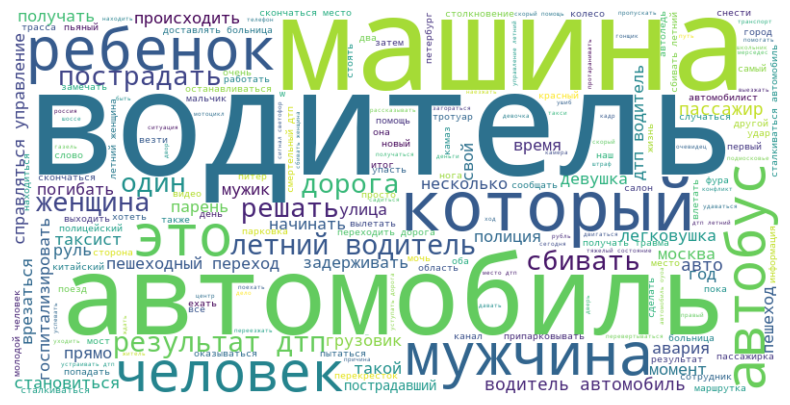

In [644]:
wordcloud_car = WordCloud(width=800, height=400, background_color ='white').generate(text_car)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_car, interpolation='bilinear')
plt.axis('off')
plt.show()

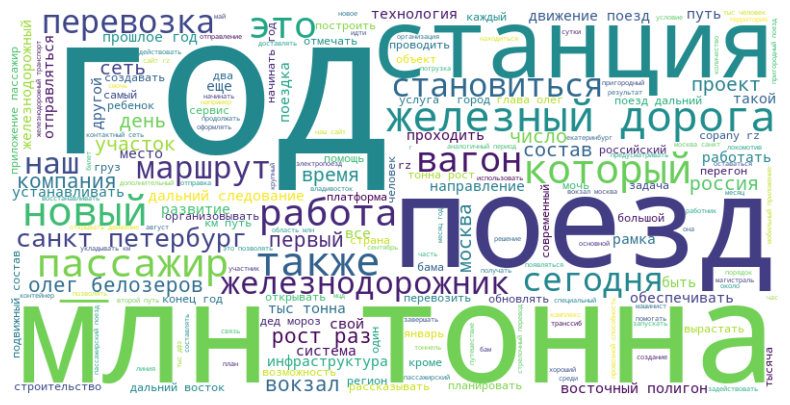

In [645]:
wordcloud_train = WordCloud(width=800, height=400, background_color ='white').generate(text_train)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.axis('off')
plt.show()

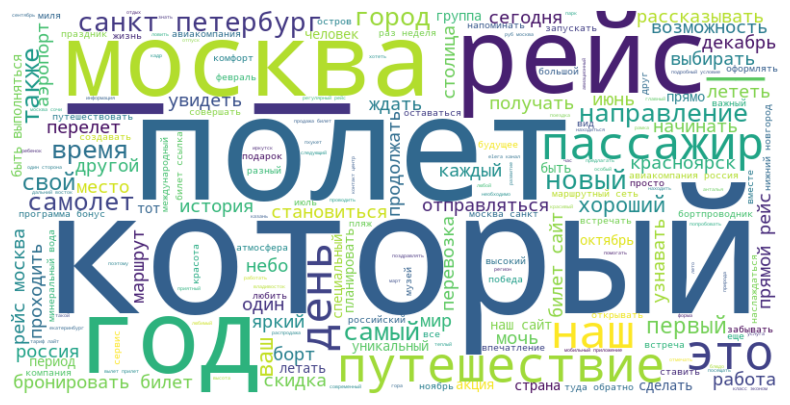

In [646]:
wordcloud_air = WordCloud(width=800, height=400, background_color ='white').generate(text_air)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_air, interpolation='bilinear')
plt.axis('off')
plt.show()

In [647]:
df.processed_text.loc[4]

'мфц wjpjjwy приходить elera многофункциональный центр wjpjjwy это центр просмотр описание порядок предоставление государственный услуга рассказывать какой услуга государство мочь получать совершенно бесплатно какой выплата полагать закон сэкономить налог wjpjjwy телегр канал мфц wjpjjwy подписываться wjpjjwy'

In [648]:
tokenizer = Tokenizer(num_words=NUM_WORDS)

In [649]:
tokenizer.fit_on_texts(df['processed_text'])

In [650]:
tokenizer.word_index

{'год': 1,
 'москва': 2,
 'поезд': 3,
 'который': 4,
 'пассажир': 5,
 'рейс': 6,
 'новый': 7,
 'наш': 8,
 'это': 9,
 'билет': 10,
 'млн': 11,
 'россия': 12,
 'тонна': 13,
 'время': 14,
 'водитель': 15,
 'дорога': 16,
 'также': 17,
 'день': 18,
 'работа': 19,
 'место': 20,
 'сайт': 21,
 'путь': 22,
 'направление': 23,
 'перевозка': 24,
 'тыс': 25,
 'первый': 26,
 'станция': 27,
 'движение': 28,
 'полет': 29,
 'петербург': 30,
 'быть': 31,
 'область': 32,
 'автомобиль': 33,
 'путешествие': 34,
 'самый': 35,
 'один': 36,
 'санкт': 37,
 'становиться': 38,
 'человек': 39,
 'вагон': 40,
 'al': 41,
 'железный': 42,
 'летний': 43,
 'свой': 44,
 'сегодня': 45,
 'вокзал': 46,
 'железнодорожный': 47,
 'груз': 48,
 'раз': 49,
 'компания': 50,
 'получать': 51,
 'сеть': 52,
 'город': 53,
 'маршрут': 54,
 'машина': 55,
 'начинать': 56,
 'сочи': 57,
 'дтп': 58,
 'км': 59,
 'rz': 60,
 'другой': 61,
 'самолет': 62,
 'дальний': 63,
 'страна': 64,
 'состав': 65,
 'i': 66,
 'российский': 67,
 'открывать': 

In [651]:
for channel_name in all_classes:
    print(f'{channel_name} in tokenizer is', channel_name in tokenizer.word_index)

АВТО БАТЯ in tokenizer is False
АЭРОФЛОТ in tokenizer is False
Телеграмма РЖД in tokenizer is False


In [652]:
TOKENIZER_PATH = './learned_models'

with open(f'{TOKENIZER_PATH}/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [653]:
sequences = tokenizer.texts_to_sequences(df['processed_text'])

In [654]:
EXAMPLE_INDEX = 1

print(df.iloc[EXAMPLE_INDEX]['processed_text'])
print(sequences[EXAMPLE_INDEX])

сравнивать ру оглашать победитель ежегодный премия номинация каско год исход весьма закономерный пользователь маркетплейс важно эксперт отдавать eooi pre proo i liero inorah poeil noinaii kako oa ezheonoi preii rani предпочтение страховой гигант ингосстрах высоко оценивать предлагать клиент арсенал продукт добавлять кредит доверие полюбиться обладатель полис компания мобильный приложение inooile благодаря который услуга страховщик доступный буквально движение палец премия сравнивать молодой проводиться второй учитывать репутация сам сравнивать ру обладание приз считаться весьма значимый страховой компания
[3989, 2530, 568, 1968, 820, 915, 1, 4516, 1150, 3990, 1151, 1657, 1519, 1520, 4517, 66, 4518, 4519, 3548, 1658, 1152, 318, 442, 1185, 652, 2955, 4520, 1765, 50, 175, 136, 462, 4, 146, 170, 1659, 28, 3991, 820, 3989, 569, 1153, 128, 1579, 463, 3989, 2530, 821, 2531, 4516, 2088, 3548, 50]


In [655]:
x = pad_sequences(sequences, maxlen=MAX_NEWS_LEN)

x

array([[   0,    0,    0, ...,    0,    0,  558],
       [   0,    0,    0, ..., 2088, 3548,   50],
       [   0,    0,    0, ...,  398, 2956, 4521],
       ...,
       [   0,    0,    0, ...,   38,  491,  317],
       [   0,    0,    0, ...,  413,   11,   13],
       [   0,    0,    0, ...,   46,   46, 1576]], dtype=int32)

In [656]:
x.shape

(3090, 100)

In [657]:
y = df.drop(['processed_text', 'post_text', 'tokens'], axis=1).values

y 

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [658]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [659]:
ros = RandomOverSampler(random_state=42)

x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

In [660]:
y_train_resampled

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [661]:
DIR_DATA_PATH = './data'

In [662]:
# with open(f'{DIR_DATA_PATH}/x_train.json', 'w') as f:
#     json.dump(x_train_resampled.tolist(), f)

# with open(f'{DIR_DATA_PATH}/y_train.json', 'w', encoding='utf-8') as f:
#     json.dump(y_train_resampled.tolist(), f, ensure_ascii=False)

In [663]:
# with open(f'{DIR_DATA_PATH}/x_test.json', 'w') as f:
#     json.dump(x_test.tolist(), f)

# with open(f'{DIR_DATA_PATH}/y_test.json', 'w', encoding='utf-8') as f:
#     json.dump(y_test.tolist(), f, ensure_ascii=False)